In [18]:
import torch
import torch.nn as nn
import torchvision
import cv2
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
train_data_df = pd.read_csv('training.csv')
test_data_df = pd.read_csv('test.csv')
train_data_df = train_data_df[[col for col in train_data_df.columns if col.startswith("mouth") or col.startswith("Image")]]
test_data_df = test_data_df[[col for col in test_data_df.columns if col.startswith("mouth") or col.startswith("Image")]]

train_data_df.head(1)


,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [42]:
from sklearn.impute import KNNImputer

print(train_data_df.isna().sum())  # Count NaNs in each column

imputer = KNNImputer(n_neighbors=5)  # Nutze die 5 nächsten Nachbarn
train_data_df.iloc[:, :-1] = imputer.fit_transform(train_data_df.iloc[:, :-1])

print(train_data_df.isna().sum())  # Count NaNs in eac

mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64


In [27]:
# Convert data into images
def convert_images(image_data):
    image = np.array(image_data, dtype=np.uint8)
    image = image.reshape(96, 96)  # Reshape in 96x96 Bild
    return image

# Convert images function for train and validation
def process_images(data, labels_df, start_idx, end_idx):
    converted_images = []
    labels = []
    for i in range(start_idx, end_idx):
        image_data = data[i].split(" ")
        converted_images.append(convert_images(image_data))
        labels.append(labels_df.iloc[i, :8]) 
    return converted_images, labels

train_images_data = train_data_df.iloc[:, -1]

# Process training and validation images and labels
train_converted_images, train_label = process_images(train_images_data, train_data_df, 0, len(train_images_data))

Text(0.5, 1.0, 'Image with Facial Keypoints')

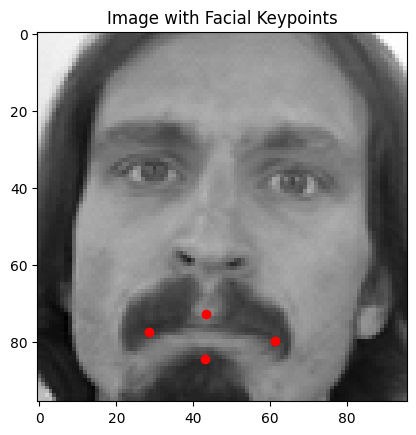

In [15]:
x_coords = train_label[0][::2]  # Alle x-Koordinaten (ungerade Indizes)
y_coords = train_label[0][1::2]  # Alle y-Koordinaten (gerade Indizes)

# Bild anzeigen (Graustufen)
plt.imshow(train_converted_images[0], cmap='gray')

# Punkte anzeigen
plt.scatter(x_coords, y_coords, c='red', marker='o')

# Titel setzen und das Bild anzeigen
plt.title("Image with Facial Keypoints")

## Dataset Class

In [65]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image

# 1. Transformations mit Keypoint-Anpassung
class KeypointTransforms:
    @staticmethod
    def train_transform():
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    @staticmethod
    def val_transform():
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

# 2. Verbesserte Dataset-Klasse
class FacialKeypointsDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Neuer Ansatz:
        - Nimmt direkt das DataFrame
        - Verarbeitet Images und Labels zusammen
        - Transformationslogik zentralisiert
        """
        self.df = df
        self.transform = transform
        
        # Vorverarbeitung bei Initialisierung
        self.images = []
        self.labels = []
        self._preprocess_data()
    
    def _preprocess_data(self):
        """Lädt und normalisiert alle Daten einmalig"""
        for _, row in self.df.iterrows():
            # Bild aus String laden
            img = np.array(row['Image'].split(), dtype=np.float32).reshape(96, 96)
            
            # Keypoints normalisieren (0-1)
            keypoints = row.values[:8].astype(np.float32) / 96.0
            
            self.images.append(img)
            self.labels.append(keypoints)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Wichtigste Änderungen:
        - Keypoint-Anpassung bei Transformationen
        - Korrekte PIL Image Konvertierung
        - Keine doppelte Normalisierung
        """
        image = self.images[idx].copy()
        label = self.labels[idx].copy()
        
        if self.transform:
            # Konvertiere zu PIL Image für Transforms
            image = Image.fromarray((image * 255).astype(np.uint8))
            
            # Merke Original-Keypoints
            original_label = label.copy()
            
            # Wende Transformationen nacheinander an
            for t in self.transform.transforms:
                if isinstance(t, transforms.RandomHorizontalFlip):
                    if np.random.rand() < t.p:
                        image = transforms.functional.hflip(image)
                        # Spiegle x-Koordinaten
                        label[::2] = 1.0 - label[::2]
                
                elif isinstance(t, transforms.RandomRotation):
                    angle = t.get_params(t.degrees)
                    image = transforms.functional.rotate(image, angle)
                    # Hier müsste Keypoint-Rotation implementiert werden
                    # (Für 10° Rotation vereinfacht annehmen)
                
                else:
                    image = t(image)
            
            # Konvertiere zurück zu Tensor
            if isinstance(image, Image.Image):
                image = transforms.ToTensor()(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# 3. DataLoader-Erstellung
def create_datasets(df, train_size=6500):
    # Aufteilung in Train/Val
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    return (
        FacialKeypointsDataset(train_df, transform=KeypointTransforms.train_transform()),
        FacialKeypointsDataset(val_df, transform=KeypointTransforms.val_transform())
    )

# Verwendungsbeispiel
# df = pd.read_csv('...')
# train_dataset, val_dataset = create_datasets(df)

# DataLoader mit verbesserten Einstellungen
def create_loaders(train_dataset, val_dataset, batch_size=32):
    return (
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        ),
        DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )
    )

## Model Architecture

In [66]:
import torch
import torch.nn as nn
import torch.nn.init as init

class LipDetectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Erweiterte Convolutional Layers mit Initialisierung
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 96x96 -> 48x48
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 48x48 -> 24x24
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 24x24 -> 12x12
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((6, 6))  # 12x12 -> 6x6
        )

        # Verbesserte Fully-Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(512*6*6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 8),
            nn.Sigmoid()  # Wichtig für [0,1] Output
        )

        # Gewichtsinitialisierung
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

## Training Loop

In [71]:
import torch
import torch.nn as nn
import csv
from torch.utils.data import DataLoader
import numpy as np
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-7
)

def save_loss_to_csv(epoch, batch, train_loss, val_loss, lr):
    with open('training_loss.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch,
            batch,
            f"{train_loss:.4f}",
            f"{val_loss:.4f}",
            f"{lr:.2e}",
            datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ])

max_grad_norm = 1.0

num_epochs = 100
best_val_loss = float('inf')
patience_counter = 0
patience = 10

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    total_batches = len(train_loader)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        if (batch_idx + 1) % 20 == 0:
            avg_train_loss = epoch_train_loss / (batch_idx + 1)
            current_lr = optimizer.param_groups[0]['lr']
            
            if (batch_idx + 1) % int(0.2 * total_batches) == 0:
                avg_val_loss = validate(model, val_loader)
                save_loss_to_csv(epoch, batch_idx+1, avg_train_loss, avg_val_loss, current_lr)
            
    avg_train_loss = epoch_train_loss / total_batches
    avg_val_loss = validate(model, val_loader)
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    print(f'Epoch [{epoch+1:03d}/{num_epochs}] '
          f'Train: {avg_train_loss:.4f} | '
          f'Val: {avg_val_loss:.4f} | '
          f'LR: {current_lr:.1e} | '
          f'Best Val: {best_val_loss:.4f}')
    
    if patience_counter >= patience and avg_val_loss > best_val_loss * 1.2:
        print(f'Early stopping at epoch {epoch+1}')
        break

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-71-2653d6566466>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Exception in thread Thread-186 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storag

KeyboardInterrupt: 